**Implementing a two-layer perceptron.** In this coding session, we will get some practice implementing a two-layer perceptron. The code in this session is heavily borrowed from the [Machine Learning with PyTorch and Scikit-learn book's Github repo](https://github.com/rasbt/machine-learning-book/tree/main).

**Notation for neural networks.** As in lecture, let's use the following notation for a neural network: let $(V, E, w)$ be a directed, weighted graph, and suppose the vertex set $V$ can be split into disjoint sets of vertices, $V = \bigcup_{\ell = 0}^L V_\ell$ such that if $e \in E$ then $e = (v, v')$ for $v \in V_{\ell}$ and $v' \in V_{\ell + 1}$ for some $\ell = 0, 1, \ldots, L - 1\}$. The number $L$ is called the number of *layers* of the neural network. The integers $d_{\rm in} := |V_0|$ and $d_{\rm out} := |V_L|$ are called the *input* and *output* dimensions of the network. The parameter $w$ are the *weights*, which we can think of either as a function $w \colon E \to \mathbb{R}$, or as a collection of matrices $(W_1, \ldots, W_{L})$ where each $W_\ell \in \mathbb{R}^{|V_{\ell}| \times |V_{\ell - 1}|}$, along with biases $b_1, \ldots, b_L$ such that $b_\ell \in \mathbb{R}^{|V_{\ell}|}$.

We assume as given a non-linearity $\sigma \colon \mathbb{R} \to \mathbb{R}$, for example a ReLU unit ($\sigma(\tau) := \max(0, \tau)$), a logistic unit ($\sigma(\tau) = (1 + e^{-\tau})^{-1}$) or something else.

The network then generates output via a *forward pass*. Given an input $x \in \mathbb{R}^{d_{\rm in}}$, we calculate the output $o_0(x) = (x_1, \ldots, x_d, 1)$, and then for subsequent layers we put $a_\ell(x) = W_\ell o_{\ell - 1}(x) + b_\ell$ and $o_{\ell}(x) := \sigma(a_{\ell}(x))$ for output. The output of the network is, finally, $o_L(x)$.

**Specializing to a two-layer perceptron.** In this lab, we will get into the nitty gritty details of a two-layer, fully connected, perceptron.

**Importing and preparing the MNIST dataset** We will use the MNIST dataset, which is a collection of images of handwritten digits (1, 2, ... , 9) half written by high school students and half written by employees of the US Census Bureau.

In [2]:
import numpy as np

from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

X = X.values
y = y.astype(int).values

### ALTERNATIVE CODE IN CASE THE ABOVE DOESN'T WORK (requires pytorch) ###

# import numpy as np
# from torchvision import datasets, transforms

# mnist = datasets.MNIST(root='.', download=True)

# X = mnist.data.numpy()      # (60000, 28, 28)
# y = mnist.targets.numpy()   # (60000,)

# # For the test set
# mnist_test = datasets.MNIST(root='.', train=False, download=True)
# X_test = mnist_test.data.numpy()
# y_test = mnist_test.targets.numpy()

# # Combine
# X = np.concatenate([X, X_test], axis=0)  # (70000, 28, 28)
# X = X.reshape(X.shape[0], -1)  # (70000, 784)
# y = np.concatenate([y, y_test], axis=0)

print(X.shape, y.shape)

/Users/astromme_1/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 7148828.10it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 344046.55it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2369178.07it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 1010209.39it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

(70000, 28, 28)
(70000,)


The images in the MNIST dataset consist of 28×28 pixels, and each pixel is represented by a grayscale intensity value. Here, fetch_openml already unrolled the 28×28 pixels into one-dimensional row vectors, which are the rows in our X array (784 per row or image) above. The second array (y) returned by the fetch_openml function contains the corresponding target variable, the class labels (integers 0-9) of the handwritten digits.

Next, let’s normalize the pixels values in MNIST to the range –1 to 1 (originally 0 to 255):

In [3]:
X = (X/255. - .5)*2

We'll be using gradient descent based methods to train out model, and for these methods it is especially important that the features are normalized. Now let's visualize the first elements of each class.

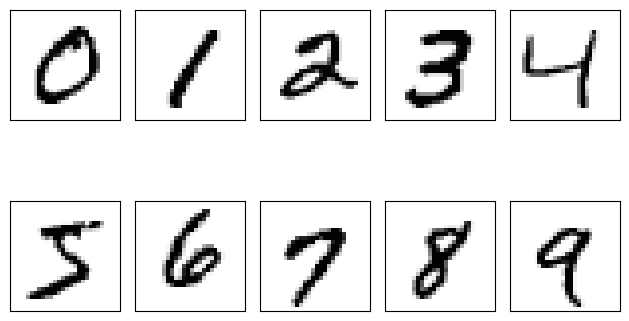

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Now let's plot different 7s:

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Finally, we will split the dataset into training, validation, and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

# # optional to free up some memory by deleting non-used arrays:
# del X_temp, y_temp, X, y

**Building a basic two-layer perceptron class.** We'll now work on implementing a basic two-layer neural network model. To this end, we'll need to handle a detail involving the encoding of the class labels. As they currently stand, the class labels are integers in $[9]$, but to work with them in a neural network model, we'll need to use an encoding to the output dimension. The encoding we'll use is known as a *one-hot* encoding, where the label $i \in [9]$ is mapped to the $i + 1$st basis vector in $\mathbb{R}^{10}$. The code for this encoding follows.

In [ ]:
def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

**Affine forward.** Let's now start to implement the basic layers of our neural network, beginning with the forward pass for the affine layer: this is the layer which takes as input $X \in \mathbb{R}^{n \times d}$ and maps it to $XW$ for $W \in \mathbb{R}^{d \times m}$.

In [ ]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, D) and contains a minibatch of N
    examples, where each example x[i] has shape (D,).

    Inputs:
    - x: A numpy array containing input data, of shape (N, D)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None

    # ***** START OF YOUR CODE *****

    # ***** END OF YOUR CODE *****

    cache = (x, w, b)
    return out, cache

Check that your implementation here is correct by using the following code. Check that the above is correct with the following code.

In [ ]:
# Test the affine_forward function

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

num_inputs = 2
input_shape = (120,)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

**Affine backward.** Now implement the backward pass for an affine layer. For this, it is helpful to think about what the following should be: if $g \colon \mathbb{R}^{l \times n} \to \mathbb{R}$ and $A \in \mathbb{R}^{l \times m}$, $B \in \mathbb{R}^{m \times n}$, then what is
$$
\nabla_Ag(AB) = \, \, ?
$$

In [ ]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, D)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, D)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    
    # ***** START OF YOUR CODE *****

    # ***** END OF YOUR CODE *****
    
    return dx, dw, db

Check that the above is correct with the following code.

In [ ]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 6)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

**ReLU forward.** Next, implement the ReLU forward pass. Recall that this is $\mathrm{ReLU}(x) = \max(0, x)$. 

In [ ]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None

    # ***** START OF YOUR CODE *****

    # ***** END OF YOUR CODE *****

    cache = x
    return out, cache

Test your implementation of the forward ReLU operation with the following.

In [ ]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

**ReLU backward.** Finally, implement the backward ReLU operation. Note that there's no need to worry about differentiability at $0$.

In [ ]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache

    # ***** START OF YOUR CODE *****

    # ***** END OF YOUR CODE *****

    return dx

Test your backward ReLU implementation with the following.

In [ ]:
np.random.seed(231)

sz = 10
x = np.random.randn(sz, sz + 1)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

The following code conveniently encapsulates the logical of an affine to ReLU layer, and should be a helpful reference for the implentation of ```TwoLayerNN``` below.

In [ ]:
def affine_relu_forward(x, w, b):
    """
    Convenience layer that perorms an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db


Now that we've implemented our layers, let's make our  2 layer perceptron. Because it has two layers, its constructor will accept three integers, each corresponding to the number of nodes at each layer. An important detail to observe is that when we initialize the weights of our perceptron, we initialize them *randomly*. For now, we will ignore the details of the backpropogation which is necessary for training, and you will implement part of the initialization method as well as part of the forward propogation method.

In [ ]:
class TwoLayerNN(object):
    """
    A two-layer fully-connected neural network with sigmoid nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        self.num_classes = num_classes
        
        rng = np.random.RandomState(random_seed)

        self.params = {}
        self.params['weight_in'] = rng.normal(
            loc=0.0, scale=0.001, size=(num_features, num_hidden))
        self.params['bias_in'] = np.zeros(num_hidden)
        
        # Initialize second weight matrix
        self.params['weight_out'] = rng.normal(
            loc=0.0, scale=0.001, size=(num_hidden, num_classes))
        self.params['bias_out'] = np.zeros(num_classes)

    def loss(self, X, y=None): 
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, D)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        if y is None:
            out1, cache1 = affine_relu_forward(X, self.params['weight_in'], self.params['bias_in'])
            out2, cache2 = affine_forward(out1, self.params['weight_out'], self.params['bias_out'])

            return out2

        if y is not None:
            out1, cache1 = affine_relu_forward(X, self.params['weight_in'], self.params['bias_in'])
            out2, cache2 = affine_forward(out1, self.params['weight_out'], self.params['bias_out'])
            loss = None
            grads = {}

            # ***** START OF YOUR CODE ***** #

            # ***** END OF YOUR CODE ***** #

            grads['weight_in'] = dweight_in
            grads['bias_in'] = dbias_in
            grads['weight_out'] = dweight_out
            grads['bias_out'] = dbias_out

            return loss, grads

Let's initialize our model; we'll make the hidden layer have 50 units.

In [ ]:
tnn = TwoLayerNN(num_features=28*28, num_hidden=50, num_classes=10)

**Reminders on GD, SGD, and mini-batch SGD.** Now, we'll a form of gradient descent to train out model. Here's a brief reminder on gradient descent methods (we'll go into more detail in lectures).

Suppose we want to solve the minimization problem
$$
\min_{\theta \in \mathbb{R}^d} f(\theta).
$$ The function $f$ is called the *objective*. Then gradient descent uses the iteration, for some initial point $\theta_0$,
$$
\theta_{t + 1} = \theta_t - \eta_t \nabla f(\theta_t),
$$ where $\eta_t \in \mathbb{R}$ is a *learning rate* that is specified by the user (typically a constant in the case of gradient descent proper).

An objective $f$ that arises frequently in statistics and machine learning is of the form
$$
f(\theta) = \frac1n \sum_{i = 1}^n \ell(h_{\theta}(x_i), y_i),
$$ where $\ell$ is a loss function and $(h_{\theta})_{\theta \in \Theta}$ is a parametrized model class. Indeed, this objective corresponds to an *empirical loss*. For example, in the setting of two layer perceptrons we'll use $\ell(z , y) := \| z - y \|^2$ the $\ell_2$-loss, and $h_{\theta}$ the neural network with parameters $\theta = (W_1, W_2, b_1, b_2)$, and the sum will be over the training data of MNIST. Often (and in our case), the $n$ will be very large, making direct computation of $\nabla f(\theta)$ impractical and thus ruling out the gradient descent algorithm.

A work-around for this issue, which has additional attractive properties that we won't discuss now, is called *stochastic gradient descent (SGD)*. Here, we take a uniformly random $i \in [n]$, and use it to form a *stochastic gradient*
$$
\hat \nabla f(\theta) := \nabla_\theta \ell(h_{\theta}(x_i), y_i).
$$ Observe that, over the randomness of this uniform random sample, $\mathbb{E}[\hat \nabla f(\theta)] = \nabla f(\theta)$. It is thus plausible that we can use this stochastic gradient as a replacement for the full gradient $\nabla f(\theta)$, and run a stochastic version of the gradient descent algorithm. This is called *stochastic gradient descent*, and uses the updates
$$
\theta_{t + 1} = \theta_t - \eta_t \hat \nabla f(\theta_t),
$$ where, importantly, we use fresh randomness at each iteration to form the stochastic gradient $\hat \nabla f(\theta_t)$.

Finally, the SGD algorithm can be excessively noisy due to the fact that we use only one data point to form the stochastic gradient $\hat \nabla f(\theta_t)$. This is remedied by averaging over several stochastic gradients to produce *mini-batch SGD*. Specifically, let $M$ be a fixed positive integer (the mini-batch size) and let $\{i_1, \ldots, i_M\} \subset [n]$ be a random subset of $M$ integers in $[n]$. Then we can form the averaged stochastic gradient
$$
\bar \nabla^M f(\theta) := \frac1M \sum_{m = 1 }^M \nabla_\theta \ell(h_{\theta}(x_{i_m}), y_{i_m})
$$ The minibatch SGD algorithm is then
$$
\theta_{t + 1} = \theta_t - \eta_t \bar \nabla^M f(\theta_t).
$$ In practice, the way the randomness for the minibatch data or SGD is typically generated is by first randomly permuting the training data, and then iterating through the permuted data until there is no more data left, and then re-permuting the data and starting over again. Each iteration through the training data is referred to as an *epoch*.

The following utility function (no need to read carefully) generates minibatches appropriate for our use.

In [ ]:
num_epochs = 50
minibatch_size = 400

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

Let's now define functions that compute the MSE and accuracy of our model, and check that they give reasonable numbers when run on our existing model (remember, we haven't trained it yet so it is merely randomly initialized).

In [ ]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return (0.5 / np.shape(targets)[0]) * np.linalg.norm(onehot_targets - probas)**2
    
def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

probas = tnn.loss(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

This is a plausible accuracy (about 1/10) since we initialized the weights randomly.

Now, we'll use the minibatch method to implement a version of the above methods that will scale to very large data sets where we might otherwise run into memory issue. There's no need to look at this method in detail.

In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        probas = nnet.loss(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = (0.5 / np.shape(targets)[0]) * np.linalg.norm(onehot_targets - probas)**2
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

We'll get the same result as before using this large-scale version of the previous methods:

In [ ]:
mse, acc = compute_mse_and_acc(tnn, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

We can now, finally, implement the training method! Note that we will be keeping track of the train and validation MSE and accuracy throughout the optimization so we can make plots below. 

In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            mini_onehots = int_to_onehot(y_train_mini, num_labels=10)

            # ***** START OF YOUR CODE ***** #

            # ***** END OF YOUR CODE ***** #
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

Let's see what it does.

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    tnn, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.0001)

In [ ]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

Now we can plot the accuracy of the training and validation 

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

We finally look at the ultimate test accuracy of the trained model, and plot some of the misclassified digits.

In [ ]:
test_mse, test_acc = compute_mse_and_acc(tnn, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

probas = tnn.loss(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()